In [ ]:
!pip install spotipy python-dotenv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 9.7 MB/s eta 0:00:00


In [ ]:
CLIENT_ID='75761f28a5a94634959f14a89d8c7563'
CLIENT_SECRET='2e6458aea5fe43589181dcc9f098e0ab'

In [ ]:
import os
import re
import csv
import time
import spotipy
from dotenv import load_dotenv
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.exceptions import SpotifyException

# Load credentials from .env file
load_dotenv()
OUTPUT_FILE_NAME = "Spotify.csv"

# List of target playlists
PLAYLIST_LINKS = [
    'https://open.spotify.com/playlist/5rjfioSxWkmzlsCdgNeePc?si=bf08767260404c0e'
]

# Authenticate with Spotify API
client_credentials_manager = SpotifyClientCredentials(
    client_id=CLIENT_ID,
    client_secret=CLIENT_SECRET
)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

# Function to infer mood based on valence and energy values
def infer_mood(valence, energy):
    if valence >= 0.5 and energy >= 0.5:
        return "happy"
    elif valence < 0.5 and energy < 0.5:
        return "sad"
    elif valence < 0.5 and energy >= 0.5:
        return "energetic"
    else:
        return "calm"

# Function to handle rate limits
def retry_with_sleep(api_call, *args, **kwargs):
    while True:
        try:
            return api_call(*args, **kwargs)
        except SpotifyException as e:
            if e.http_status == 429:
                wait_time = int(e.headers.get("Retry-After", 5))
                print(f"Rate limit exceeded. Sleeping for {wait_time} seconds...")
                time.sleep(wait_time)
            else:
                print(f"Error: {e}")
                return None

# Create CSV file and write header
with open(OUTPUT_FILE_NAME, "w", encoding="utf-8") as file:
    writer = csv.writer(file)
    writer.writerow(["track_id", "name", "artist", "album", "date", "duration_ms", "mood"])

    # Loop through each playlist link
    for PLAYLIST_LINK in PLAYLIST_LINKS:
        if match := re.match(r"https://open.spotify.com/playlist/(.*)\?", PLAYLIST_LINK):
            playlist_uri = match.groups()[0]
        else:
            print(f"Invalid playlist link format: {PLAYLIST_LINK}")
            continue

        # Fetch all tracks in the playlist
        offset = 0
        while True:
            response = retry_with_sleep(sp.playlist_tracks, playlist_uri, offset=offset)
            if not response or not response["items"]:
                break  # No more tracks to fetch

            for track in response["items"]:
                track_info = track["track"]
                if not track_info:
                    continue

                track_id = track_info.get("id", "N/A")
                name = track_info.get("name", "Unknown")
                artists = ", ".join([artist["name"] for artist in track_info.get("artists", [])])
                album = track_info["album"]["name"] if track_info.get("album") else "Unknown Album"
                release_date = track_info["album"].get("release_date", "Unknown Date") if track_info.get("album") else "Unknown Date"
                date = release_date.split("-")[0]  # Extract only the year
                duration_ms = track_info.get("duration_ms", 0)

                # Get mood using audio features with retry mechanism
                mood = "unknown"
                audio_features = retry_with_sleep(sp.audio_features, track_id)
                if audio_features and audio_features[0]:
                    valence = audio_features[0]["valence"]
                    energy = audio_features[0]["energy"]
                    mood = infer_mood(valence, energy)

                # Write the row to the CSV
                writer.writerow([track_id, name, artists, album, date, duration_ms, mood])

            # Increment offset to fetch the next batch of tracks
            offset += len(response["items"])

print(f"Data has been saved to {OUTPUT_FILE_NAME}.")


In [ ]:
CLIENT_ID='75761f28a5a94634959f14a89d8c7563'
CLIENT_SECRET='2e6458aea5fe43589181dcc9f098e0ab'

In [ ]:
load_dotenv()
print("Client ID:", os.getenv("SPOTIPY_CLIENT_ID"))  # Should print your actual Client ID


Client ID: None


In [ ]:
import os
import re
import csv
import time
import spotipy
from dotenv import load_dotenv
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.exceptions import SpotifyException

# Load credentials from .env file
load_dotenv()
OUTPUT_FILE_NAME = "Spotify_updated_3.csv"

# List of target playlists
PLAYLIST_LINKS = [
    'https://open.spotify.com/playlist/5rjfioSxWkmzlsCdgNeePc?si=bf08767260404c0e'
]

# Authenticate with Spotify API
client_credentials_manager = SpotifyClientCredentials(
    client_id=CLIENT_ID,
    client_secret=CLIENT_SECRET
)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

# Function to infer mood based on valence and energy values
def infer_mood(valence, energy):
    if valence >= 0.5 and energy >= 0.5:
        return "happy"
    elif valence < 0.5 and energy < 0.5:
        return "sad"
    elif valence < 0.5 and energy >= 0.5:
        return "energetic"
    else:
        return "calm"

# Function to handle rate limits with max retry limit of 3
def retry_with_sleep(api_call, *args, **kwargs):
    attempts = 0
    while attempts < 3:
        try:
            return api_call(*args, **kwargs)
        except SpotifyException as e:
            if e.http_status == 429:
                wait_time = int(e.headers.get("Retry-After", 5))
                print(f"Rate limit exceeded. Sleeping for {wait_time} seconds... (Attempt {attempts + 1}/3)")
                time.sleep(wait_time)
                attempts += 1
            else:
                print(f"Error: {e}")
                return None
    print("Max retry attempts reached.")
    return None

# Create CSV file and write header
with open(OUTPUT_FILE_NAME, "w", encoding="utf-8") as file:
    writer = csv.writer(file)
    writer.writerow(["track_id", "track_name", "artists", "album", "release_year", "duration_ms", "mood"])

    # Loop through each playlist link
    for PLAYLIST_LINK in PLAYLIST_LINKS:
        if match := re.match(r"https://open.spotify.com/playlist/(.*)\?", PLAYLIST_LINK):
            playlist_uri = match.groups()[0]
        else:
            print(f"Invalid playlist link format: {PLAYLIST_LINK}")
            continue

        # Fetch tracks starting from the 1902nd track in the playlist
        offset = 3883
        while True:
            response = retry_with_sleep(sp.playlist_tracks, playlist_uri, offset=offset)
            if not response or not response["items"]:
                break  # No more tracks to fetch

            for track in response["items"]:
                track_info = track["track"]
                if not track_info:
                    continue

                track_id = track_info.get("id", "N/A")
                name = track_info.get("name", "Unknown")
                artists = ", ".join([artist["name"] for artist in track_info.get("artists", [])])
                album = track_info["album"]["name"] if track_info.get("album") else "Unknown Album"
                release_date = track_info["album"].get("release_date", "Unknown Date") if track_info.get("album") else "Unknown Date"
                date = release_date.split("-")[0]  # Extract only the year
                duration_ms = track_info.get("duration_ms", 0)

                # Get mood using audio features with retry mechanism
                mood = "unknown"
                audio_features = retry_with_sleep(sp.audio_features, track_id)
                if audio_features and audio_features[0]:
                    valence = audio_features[0]["valence"]
                    energy = audio_features[0]["energy"]
                    mood = infer_mood(valence, energy)

                # Write the row to the CSV
                writer.writerow([track_id, name, artists, album, date, duration_ms, mood])

            # Increment offset to fetch the next batch of tracks
            offset += len(response["items"])

print(f"Data has been saved to {OUTPUT_FILE_NAME}.")


In [ ]:
import pandas as pd

# Load the Spotify data
df = pd.read_csv("Spotify_changed.csv")

# Step 1: Remove duplicate songs by unique track_id
df = df.drop_duplicates(subset="track_id")

# Step 2: Filter out rows where 'release_year' is "0" or 'mood' is "unknown"
df_cleaned = df[(df['release_year'] != "0") & (df['mood'] != "unknown")]

# Step 3: Remove rows where any column has "0", except for columns 'Harshal', 'Shubham', and 'Jiya'
cols_to_check = df_cleaned.columns.difference(['Harshal', 'Shubham', 'Jiya'])
df_cleaned = df_cleaned[~df_cleaned[cols_to_check].isin(["0"]).any(axis=1)]

# Step 4: Remove rows with any blank or missing data
df_cleaned = df_cleaned.dropna()  # Drops rows with any missing values

# Step 5: Save the cleaned data to a new CSV file
df_cleaned.to_csv("Spotify_updated_2.csv", index=False)

print("Duplicates removed, data cleaned, and blank cells handled. Saved to 'Spotify_updated_2.csv'")


Duplicates removed, data cleaned, and blank cells handled. Saved to 'Spotify_updated_2.csv'


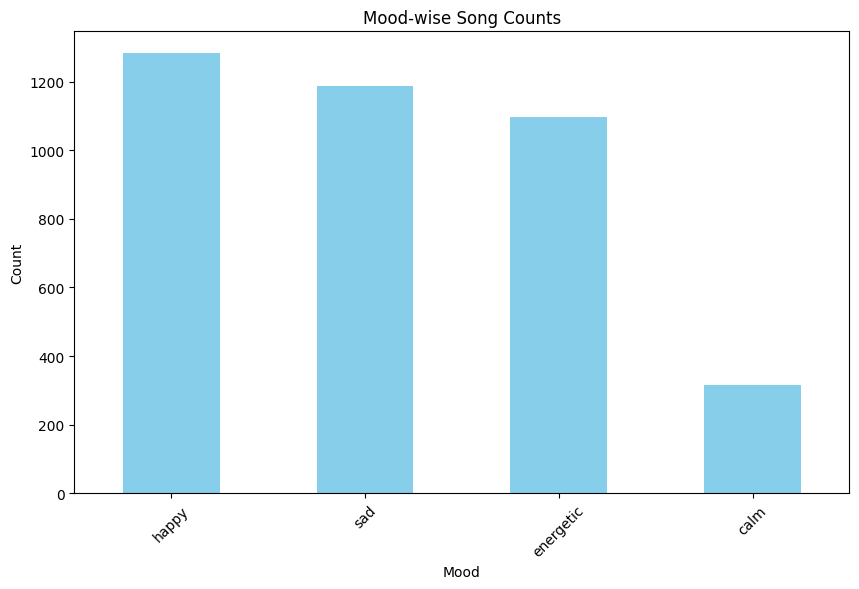

Mood-wise counts:
mood
happy        1282
sad          1186
energetic    1098
calm          317
Name: count, dtype: int64


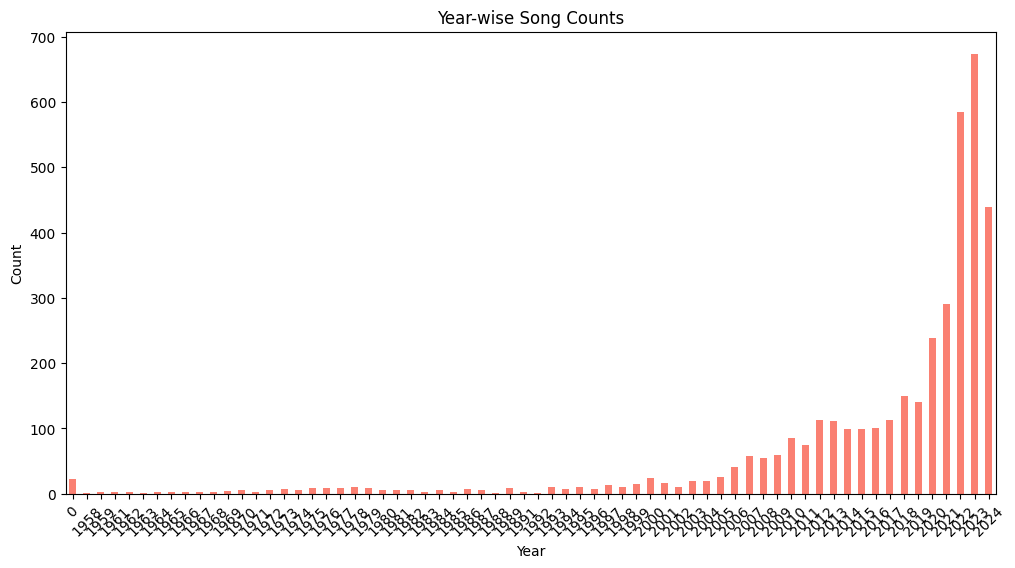


Year-wise counts:
release_year
0        22
1958      1
1959      2
1961      3
1962      3
       ... 
2020    239
2021    290
2022    585
2023    674
2024    439
Name: count, Length: 66, dtype: int64


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the cleaned Spotify data
df = pd.read_csv("Spotify_changed.csv")

# Step 1: Mood-wise counts
mood_counts = df['mood'].value_counts()

# Plot mood-wise counts
plt.figure(figsize=(10, 6))
mood_counts.plot(kind='bar', color='skyblue')
plt.title("Mood-wise Song Counts")
plt.xlabel("Mood")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

# Display mood counts with print
print("Mood-wise counts:")
print(mood_counts)

# Step 2: Year-wise counts
year_counts = df['release_year'].value_counts().sort_index()

# Plot year-wise counts
plt.figure(figsize=(12, 6))
year_counts.plot(kind='bar', color='salmon')
plt.title("Year-wise Song Counts")
plt.xlabel("Year")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

# Display year counts with print
print("\nYear-wise counts:")
print(year_counts)


In [ ]:
import pandas as pd

# Load the two CSV files
df1 = pd.read_csv("Spotify_updated.csv")
df2 = pd.read_csv("Spotify_updated_2.csv")

# Concatenate the DataFrames
df_combined = pd.concat([df1, df2], ignore_index=True)

# Optionally, remove duplicate rows if needed (e.g., based on 'track_id')
df_combined = df_combined.drop_duplicates(subset="track_id")

# Save the concatenated data to a new CSV file
df_combined.to_csv("Spotify_changed.csv", index=False)

print("CSV files concatenated and saved to 'Spotify_combined.csv'")


CSV files concatenated and saved to 'Spotify_combined.csv'
